# 03. Basic statistics, Denmark-wide
## Project: Bicycle node network loop analysis

This notebook explores basic statistics of network and loops created in notebook 02 for the whole country of Denmark, without exploring different scenarios.  
Please select `denmark` as the `study_area` in the `config.yml`.

Contact: Michael Szell (michael.szell@gmail.com)

Created: 2024-01-29  
Last modified: 2025-08-25

## To do
- [ ] Possibly refactor plotting code cells as one function

## Parameters

In [1]:
%run -i setup_parameters.py
load_data = True  # Set to False if data are huge and have already been loaded
debug = True  # Set to True for extra plots and verbosity
layout_mode = "combined"

## Functions

In [2]:
%run -i functions.py

## Load data

This can take several minutes.

In [3]:
if load_data:
    if LOOP_LENGTH_BOUND:
        llb_string = "_maxlength" + str(LOOP_LENGTH_BOUND)
    else:
        llb_string = ""

    with open(
        PATH["data_out"]
        + "loopcensus_"
        + str(LOOP_NUMNODE_BOUND)
        + llb_string
        + ".pkl",
        "rb",
    ) as f:
        allloops = pickle.load(f)
        alllooplengths = pickle.load(f)
        allloopnumnodes = pickle.load(f)
        allloopmaxslopes = pickle.load(f)
        Gnx = pickle.load(f)
        LOOP_NUMNODE_BOUND = pickle.load(f)
        nodes_id = pickle.load(f)
        nodes_coords = pickle.load(f)
        #numloops = pickle.load(f)
        faceloops = pickle.load(f)

In [4]:
G = ig.Graph.from_networkx(Gnx)
G.summary()

'IGRAPH UNW- 59 89 -- \n+ attr: _nx_name (v), name (v), nodeID (v), x (v), y (v), edge_id (e), geometry (e), has_attraction (e), has_facility (e), has_service (e), has_water (e), max_slope (e), node_end (e), node_start (e), poi_diversity (e), weight (e)'

In [5]:
if debug:
    print(faceloops.head(5))

                                            geometry
0  POLYGON ((668758.8 6232075.84, 668745.52 62320...
1  POLYGON ((664790.176 6231667.992, 664779.63 62...
2  POLYGON ((668758.8 6232075.84, 668757.862 6232...
3  POLYGON ((661676.94 6234126.14, 661674.1 62341...
4  POLYGON ((666896.12 6234528.37, 666865.84 6234...


## Basic statistics: Links, face loops, max slopes, poi diversity

### Link lengths

#### Distribution

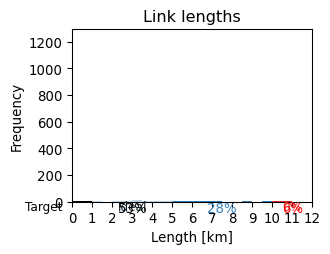

In [6]:
# All units in km
xmax = 12

fig = plt.figure(
    figsize=(320 / PLOTPARAM["dpi"], 240 / PLOTPARAM["dpi"]), dpi=PLOTPARAM["dpi"]
)
axes = fig.add_axes([0.18, 0.18, 0.75, 0.72])


linklengths = [e["weight"] * MPERUNIT / 1000 for e in G.es]

N, bins, patches = axes.hist(
    linklengths,
    bins=list(np.linspace(0, xmax, 2 * xmax + 1)),
    density=False,
    linewidth=0,
)

# Source: https://stackoverflow.com/a/49290555
for i in range(0, 2 * LINK_LIMIT[0] // 1000):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["below_ideal"])
for i in range(2 * LINK_LIMIT[0] // 1000, 2 * LINK_LIMIT[1] // 1000):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["ideal_range"])
for i in range(2 * LINK_LIMIT[1] // 1000, 2 * LINK_LIMIT[2] // 1000):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["above_ideal"])
for i in range(2 * LINK_LIMIT[2] // 1000, len(patches)):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["too_long"])

axes.set_xlabel("Length [km]")
axes.set_ylabel("Frequency")
axes.set_title("Link lengths")
axes.text(
    (LINK_LIMIT[0] + LINK_LIMIT[1]) / 2000,
    max(N) * 1.1,
    "Ideal",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["edge_classification_colors"]["ideal_range"], 5),
    fontsize=9,
)
axes.text(
    (LINK_LIMIT[0] + LINK_LIMIT[1]) / 2000,
    max(N) * 0.2,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(linklengths)
                    if (x >= LINK_LIMIT[0] / 1000 and x <= LINK_LIMIT[1] / 1000)
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
)
axes.text(
    LINK_LIMIT[0] / 1000 * 0.9,
    max(N) * 0.2,
    str(
        round(
            len([i for i, x in enumerate(linklengths) if (x <= LINK_LIMIT[0] / 1000)])
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color="#FFFFFF",
)
axes.text(
    (LINK_LIMIT[1] + LINK_LIMIT[2]) / 2000,
    max(N) * 0.2,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(linklengths)
                    if (x >= LINK_LIMIT[1] / 1000 and x <= LINK_LIMIT[2] / 1000)
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=PLOTPARAM["edge_classification_colors"]["above_ideal"],
)
axes.text(
    LINK_LIMIT[2] / 1000 * 1.05,
    max(N) * 1.1,
    "0%",
    horizontalalignment="left",
    verticalalignment="top",
    color=PLOTPARAM["edge_classification_colors"]["too_long"],
    fontsize=9,
)
axes.text(
    LINK_LIMIT[2] / 1000 * 1.05,
    max(N) * 0.2,
    str(
        round(
            len([i for i, x in enumerate(linklengths) if (x > LINK_LIMIT[2] / 1000)])
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="left",
    verticalalignment="top",
    color="red",
)

axes.text(
    -0.5,
    max(N) * 1.1,
    "Target",
    horizontalalignment="right",
    verticalalignment="top",
    color="#000000",
    fontsize=9,
)

axes.set_xticks(list(range(xmax + 1)))
axes.set_yticks(list(range(0, 1400, 200)))
axes.set_xlim([0, xmax])
axes.set_ylim([0, 1.08 * axes.get_ylim()[1]])

fig.savefig(PATH["plot"] + "linklengthhist" + "." + PLOTPARAM["format"])

#### Map with distribution

In [7]:
# define proj_crs (possibly move to config!)
proj_crs = "EPSG:25832"

/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_58416/506223430.py:5: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)


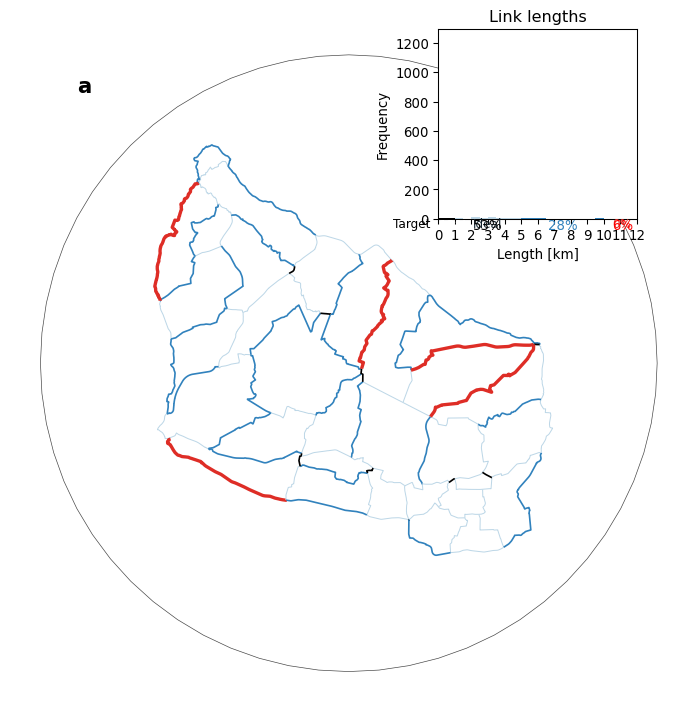

In [8]:
# Adapted from: scripts/script05.py
# in https://github.com/anastassiavybornova/bike-node-planner

# using momepy to get nodes and edges gdf with corresponding labels and geometry objects
nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)
nodes = nodes.set_crs(proj_crs)
edges = edges.set_crs(proj_crs)

### Classify edge lengths (in km)

edges["length_class"] = edges.length.apply(
    lambda x: classify_length(
        length_km=x,
        ideal_length_lower=LINK_LIMIT[0],
        ideal_length_upper=LINK_LIMIT[1],
        max_length=LINK_LIMIT[2],
    )
)

edges.to_file(PATH["data_out"] + f"edges_length_classification.gpkg", index=False)

for classification in edges.length_class.unique():
    fp = PATH["data_out"] + f"edges_{classification}.gpkg"
    edges[edges["length_class"] == classification].to_file(fp, index=False)


fig, ax = plot_dk_gdf(
    None,
    edges,
    link_width=0,
    subplotlabel="a",
)

for classification in edges.length_class.unique():
    df = gpd.read_file(PATH["data_out"] + f"edges_{classification}.gpkg")
    df.plot(
        ax=ax,
        color=PLOTPARAM["edge_classification_colors"][classification],
        aspect=1,
        linewidth=PLOTPARAM["edge_classification_linewidths"][classification],
    )


xmax = 12
axes = fig.add_axes([0.64, 0.69, 0.31, 0.25])
linklengths = [e["weight"] * MPERUNIT / 1000 for e in G.es]

N, bins, patches = axes.hist(
    linklengths,
    bins=list(np.linspace(0, xmax, 2 * xmax + 1)),
    density=False,
    linewidth=0,
)

# Source: https://stackoverflow.com/a/49290555
for i in range(0, 2 * LINK_LIMIT[0] // 1000):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["below_ideal"])
for i in range(2 * LINK_LIMIT[0] // 1000, 2 * LINK_LIMIT[1] // 1000):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["ideal_range"])
for i in range(2 * LINK_LIMIT[1] // 1000, 2 * LINK_LIMIT[2] // 1000):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["above_ideal"])
for i in range(2 * LINK_LIMIT[2] // 1000, len(patches)):
    patches[i].set_facecolor(PLOTPARAM["edge_classification_colors"]["too_long"])

axes.set_xlabel("Length [km]")
axes.set_ylabel("Frequency")
axes.set_title("Link lengths")
axes.text(
    (LINK_LIMIT[0] + LINK_LIMIT[1]) / 2000,
    max(N) * 1.1,
    "Ideal",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["edge_classification_colors"]["ideal_range"], 5),
    fontsize=9,
)
axes.text(
    (LINK_LIMIT[0] + LINK_LIMIT[1]) / 2000,
    max(N) * 0.2,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(linklengths)
                    if (x >= LINK_LIMIT[0] / 1000 and x <= LINK_LIMIT[1] / 1000)
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
)
axes.text(
    LINK_LIMIT[0] / 1000 * 0.9,
    max(N) * 0.2,
    str(
        round(
            len([i for i, x in enumerate(linklengths) if (x <= LINK_LIMIT[0] / 1000)])
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color="#FFFFFF",
)
axes.text(
    (LINK_LIMIT[1] + LINK_LIMIT[2]) / 2000,
    max(N) * 0.2,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(linklengths)
                    if (x >= LINK_LIMIT[1] / 1000 and x <= LINK_LIMIT[2] / 1000)
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=PLOTPARAM["edge_classification_colors"]["above_ideal"],
)
axes.text(
    LINK_LIMIT[2] / 1000 * 1.05,
    max(N) * 1.1,
    "0%",
    horizontalalignment="left",
    verticalalignment="top",
    color=PLOTPARAM["edge_classification_colors"]["too_long"],
    fontsize=9,
)
axes.text(
    LINK_LIMIT[2] / 1000 * 1.05,
    max(N) * 0.2,
    str(
        round(
            len([i for i, x in enumerate(linklengths) if (x > LINK_LIMIT[2] / 1000)])
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="left",
    verticalalignment="top",
    color="red",
)

axes.text(
    -0.5,
    max(N) * 1.1,
    "Target",
    horizontalalignment="right",
    verticalalignment="top",
    color="#000000",
    fontsize=9,
)

axes.set_xticks(list(range(xmax + 1)))
axes.set_yticks(list(range(0, 1400, 200)))
axes.set_xlim([0, xmax])
axes.set_ylim([0, 1.08 * axes.get_ylim()[1]])

fig.savefig(PATH["plot"] + "linklengths" + "." + PLOTPARAM["format"])

In [9]:
ll = np.array(linklengths)
sum(ll[ll < LINK_LIMIT[0] / 1000]) / sum(ll)  # Percent of length of too short links

0.016702677397967096

### Loop lengths and nodes per loop

This can take a few minutes.

Text(1.5, 0.01, 'Bound: 30')

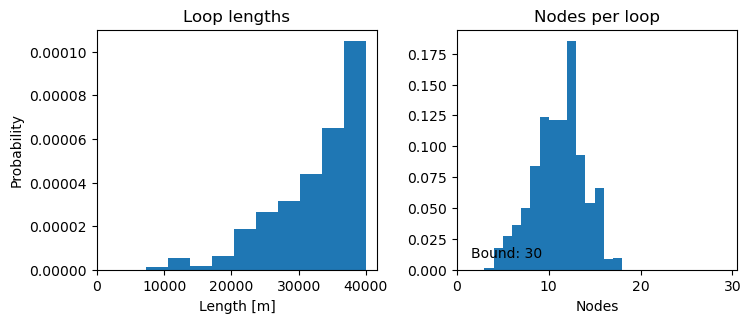

In [10]:
fig = plt.figure(figsize=(8, 3))
axes1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
axes2 = fig.add_axes([0.55, 0.1, 0.35, 0.8])

axes1.hist(alllooplengths, density=True)
if MPERUNIT == 1000:
    axes1.set_xlabel("Length [km]")
elif MPERUNIT == 1:
    axes1.set_xlabel("Length [m]")
else:
    axes1.set_xlabel("Length")
axes1.set_ylabel("Probability")
axes1.set_title("Loop lengths")
axes1.set_xlim(left=0)

axes2.hist(allloopnumnodes, density=True, bins=list(range(LOOP_NUMNODE_BOUND + 1)))
axes2.set_xlabel("Nodes")
axes2.set_title("Nodes per loop")
axes2.set_xlim([0, LOOP_NUMNODE_BOUND + 0.5])

plt.text(LOOP_NUMNODE_BOUND / 20, 0.01, "Bound: " + str(LOOP_NUMNODE_BOUND))
#plt.text(LOOP_NUMNODE_BOUND / 20, 0.04, "Loops: " + str(numloops));

In [11]:
indmaxnodes = np.where(allloopnumnodes == LOOP_NUMNODE_BOUND)[0]
if len(indmaxnodes):
    fig = plt.figure(figsize=(8, 3))
    axes1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
    axes2 = fig.add_axes([0.55, 0.1, 0.35, 0.8])

    axes1.hist(alllooplengths[indmaxnodes], density=True)
    if MPERUNIT == 1000:
        axes1.set_xlabel("Length [km]")
    elif MPERUNIT == 1:
        axes1.set_xlabel("Length [m]")
    else:
        axes1.set_xlabel("Length")
    axes1.set_ylabel("Probability")
    axes1.set_title("Loop lengths (when max nodes)")
    axes1.set_xlim(left=0)

    axes2.hist(
        allloopnumnodes[indmaxnodes],
        density=True,
        bins=list(range(LOOP_NUMNODE_BOUND + 1)),
    )
    axes2.set_xlabel("Nodes")
    axes2.set_title("Nodes per loop")
    axes2.set_xlim([0, LOOP_NUMNODE_BOUND + 0.5])

    plt.text(LOOP_NUMNODE_BOUND / 20, 0.01, "Bound: " + str(LOOP_NUMNODE_BOUND))
    #plt.text(LOOP_NUMNODE_BOUND / 20, 0.04, "Loops: " + str(numloops))
else:
    print("No loops found at number of nodes bound " + str(LOOP_NUMNODE_BOUND))

No loops found at number of nodes bound 30


### Average/median loop length per node

In [12]:
allloopavglengths = [
    sum(v["lengths"]) / len(v["lengths"]) if len(v["lengths"]) != 0 else 0
    for v in allloops.values()
]
allloopmedianlengths = [
    median(v["lengths"]) if len(v["lengths"]) != 0 else 0 for v in allloops.values()
]

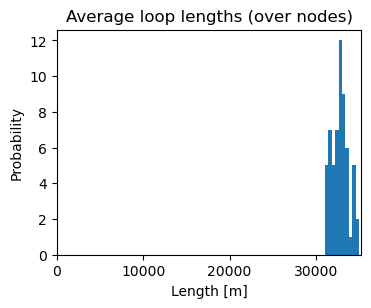

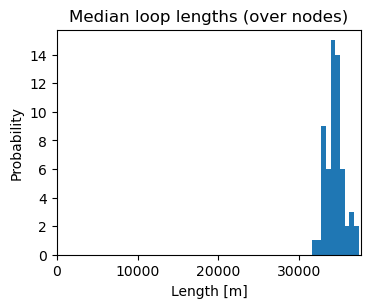

In [13]:
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0.16, 0.16, 0.76, 0.75])
axes.hist(allloopavglengths, density=False)
if MPERUNIT == 1000:
    axes.set_xlabel("Length [km]")
elif MPERUNIT == 1:
    axes.set_xlabel("Length [m]")
else:
    axes.set_xlabel("Length")
axes.set_ylabel("Probability")
axes.set_title("Average loop lengths (over nodes)")
axes.set_xlim(left=0)
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0.16, 0.16, 0.76, 0.75])
axes.hist(allloopmedianlengths, density=False)
if MPERUNIT == 1000:
    axes.set_xlabel("Length [km]")
elif MPERUNIT == 1:
    axes.set_xlabel("Length [m]")
else:
    axes.set_xlabel("Length")
axes.set_ylabel("Probability")
axes.set_title("Median loop lengths (over nodes)")
axes.set_xlim(left=0);

In [14]:
# vertex_sizes = []
# for k in range(len(allloopavglengths)):
#     try:
#         vertex_sizes.append(allloopavglengths[k])
#     except:
#         vertex_sizes.append(0)

# numloops_max = max(vertex_sizes)
# vertex_sizes = [i / (numloops_max / 10) for i in vertex_sizes]

In [15]:
# fig = plot_check(
#     G,
#     nodes_id,
#     nodes_coords,
#     vertex_size=vertex_sizes,
#     edge_width=get_edgewidth_constant(G.ecount()),
#     mode=layout_mode
# )
# plt.text(0, 0.17, "Average loop length")
# fig.savefig(PATH["plot"] + "avglooplength_" + str(LOOP_NUMNODE_BOUND) + "." + PLOTPARAM["format"]);

### Face loop lengths

#### Distribution

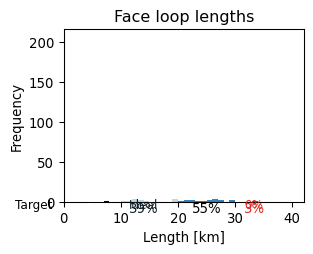

In [16]:
# All units in km
xmax = 42

fig = plt.figure(
    figsize=(320 / PLOTPARAM["dpi"], 240 / PLOTPARAM["dpi"]), dpi=PLOTPARAM["dpi"]
)
axes = fig.add_axes([0.18, 0.18, 0.75, 0.72])

facelooplengths = [c * MPERUNIT / 1000 for c in faceloops.length]

N, bins, patches = axes.hist(
    facelooplengths,
    bins=list(range(50)),
    density=False,
    edgecolor="#222222",
    linewidth=0,
)

# Source: https://stackoverflow.com/a/49290555
for i in range(0, FACELOOP_LIMIT[0] // 1000):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["below_ideal"])
for i in range(FACELOOP_LIMIT[0] // 1000, FACELOOP_LIMIT[1] // 1000):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["ideal_range"])
for i in range(FACELOOP_LIMIT[1] // 1000, FACELOOP_LIMIT[2] // 1000):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["above_ideal"])
for i in range(FACELOOP_LIMIT[2] // 1000, len(patches)):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["too_long"])


axes.set_xlabel("Length [km]")
axes.set_ylabel("Frequency")
axes.set_title("Face loop lengths")
axes.text(
    (FACELOOP_LIMIT[0] + FACELOOP_LIMIT[1]) / 2000,
    max(N) * 1.1,
    "Ideal",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["loop_classification_colors"]["ideal_range"], 5),
    fontsize=9,
)
axes.text(
    (FACELOOP_LIMIT[0] + FACELOOP_LIMIT[1]) / 2000,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x >= FACELOOP_LIMIT[0] / 1000 and x <= FACELOOP_LIMIT[1] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["loop_classification_colors"]["ideal_range"], 5),
)
axes.text(
    FACELOOP_LIMIT[0] / 1000 * 0.98,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x < FACELOOP_LIMIT[0] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="right",
    verticalalignment="top",
    color="#FFFFFF",
)
axes.text(
    (FACELOOP_LIMIT[1] + FACELOOP_LIMIT[2]) / 2000,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x >= FACELOOP_LIMIT[1] / 1000 and x <= FACELOOP_LIMIT[2] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["loop_classification_colors"]["above_ideal"], 5),
)
axes.text(
    FACELOOP_LIMIT[2] / 1000 * 1.05,
    max(N) * 1.1,
    "0%",
    horizontalalignment="left",
    verticalalignment="top",
    color=PLOTPARAM["loop_classification_colors"]["too_long"],
    fontsize=9,
)
axes.text(
    FACELOOP_LIMIT[2] / 1000 * 1.05,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x > FACELOOP_LIMIT[2] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="left",
    verticalalignment="top",
    color=PLOTPARAM["loop_classification_colors"]["too_long"],
)
axes.text(
    -2,
    max(N) * 1.1,
    "Target",
    horizontalalignment="right",
    verticalalignment="top",
    color="#000000",
    fontsize=9,
)
axes.set_xticks([0, 10, 20, 30, 40])
axes.set_yticks([0, 50, 100, 150, 200])
axes.set_xlim([0, xmax])
axes.set_ylim([0, 1.08 * axes.get_ylim()[1]])

fig.savefig(PATH["plot"] + "facelooplengthhist" + "." + PLOTPARAM["format"]);

#### Map with distribution

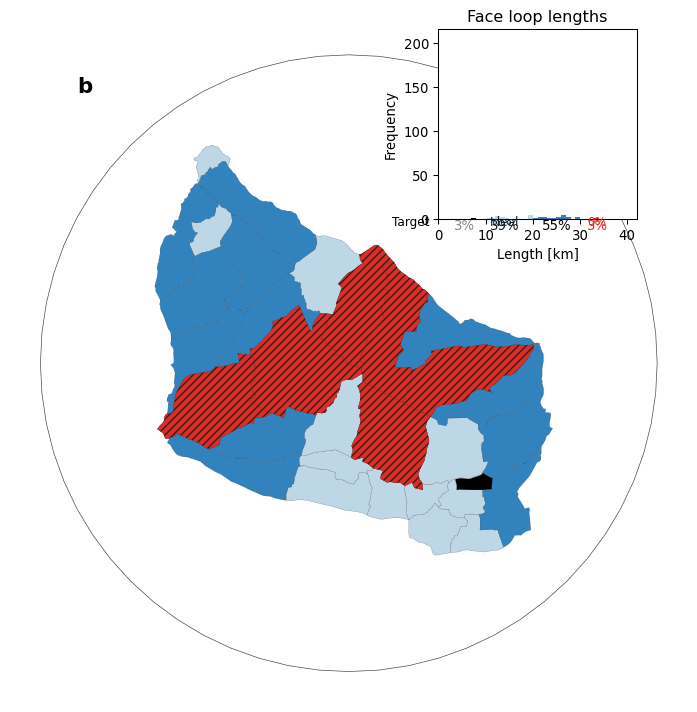

In [17]:
# Adapted from: scripts/script06.py
# in https://github.com/anastassiavybornova/bike-node-planner

loops = faceloops

loops["length_class"] = loops.length.apply(
    lambda x: classify_length(
        length_km=x,
        ideal_length_lower=FACELOOP_LIMIT[0],
        ideal_length_upper=FACELOOP_LIMIT[1],
        max_length=FACELOOP_LIMIT[2],
    )
)

fl_sorted = faceloops.iloc[faceloops.geometry.area.argsort().values]
for faceloopid in list(
    fl_sorted.tail(6).index
):  # set the 6 biggest polygons (lakes/fjords) to too_long_vacuous
    loops.loc[
        faceloopid, "length_class"
    ] = "too_long_vacuous"  # -1 due to zero-indexing

loops = loops.set_crs(proj_crs)
loops.to_file(PATH["data_out"] + f"faceloops_length_classification.gpkg", index=False)

for classification in loops.length_class.unique():
    fp = PATH["data_out"] + f"faceloops_{classification}.gpkg"
    loops[loops["length_class"] == classification].to_file(fp, index=False)


fig, ax = plot_dk_gdf(
    None,
    edges,
    link_width=0,
    subplotlabel="b",
)

for classification in loops.length_class.unique():
    df = gpd.read_file(PATH["data_out"] + f"faceloops_{classification}.gpkg")
    df = df.set_crs(proj_crs)
    df.plot(
        ax=ax,
        color=PLOTPARAM["loop_classification_colors"][classification],
        edgecolor="#222222",
        aspect=1,
        linewidth=0.12,
    )
for classification in ["too_long_vacuous"]:
    df = gpd.read_file(PATH["data_out"] + f"faceloops_{classification}.gpkg")
    df = df.set_crs(proj_crs)
    df.plot(
        ax=ax,
        color=PLOTPARAM["loop_classification_colors"][classification],
        edgecolor="#222222",
        aspect=1,
        linewidth=0.12,
        hatch="////",
        # hatchcolor = "#000000" #doesn't work for some reason. update matplotlib?
    )


xmax = 42
axes = fig.add_axes([0.64, 0.69, 0.31, 0.25])

facelooplengths = [c * MPERUNIT / 1000 for c in faceloops.length]

N, bins, patches = axes.hist(
    facelooplengths,
    bins=list(range(50)),
    density=False,
    edgecolor="#222222",
    linewidth=0,
)

# Source: https://stackoverflow.com/a/49290555
for i in range(0, FACELOOP_LIMIT[0] // 1000):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["below_ideal"])
for i in range(FACELOOP_LIMIT[0] // 1000, FACELOOP_LIMIT[1] // 1000):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["ideal_range"])
for i in range(FACELOOP_LIMIT[1] // 1000, FACELOOP_LIMIT[2] // 1000):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["above_ideal"])
for i in range(FACELOOP_LIMIT[2] // 1000, len(patches)):
    patches[i].set_facecolor(PLOTPARAM["loop_classification_colors"]["too_long"])


axes.set_xlabel("Length [km]")
axes.set_ylabel("Frequency")
axes.set_title("Face loop lengths")
axes.text(
    (FACELOOP_LIMIT[0] + FACELOOP_LIMIT[1]) / 2000,
    max(N) * 1.1,
    "Ideal",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["loop_classification_colors"]["ideal_range"], 5),
    fontsize=9,
)
axes.text(
    (FACELOOP_LIMIT[0] + FACELOOP_LIMIT[1]) / 2000,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x >= FACELOOP_LIMIT[0] / 1000 and x <= FACELOOP_LIMIT[1] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["loop_classification_colors"]["ideal_range"], 5),
)
axes.text(
    FACELOOP_LIMIT[0] / 1000 * 0.98,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x < FACELOOP_LIMIT[0] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="right",
    verticalalignment="top",
    color="#888888",
)
axes.text(
    (FACELOOP_LIMIT[1] + FACELOOP_LIMIT[2]) / 2000,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x >= FACELOOP_LIMIT[1] / 1000 and x <= FACELOOP_LIMIT[2] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["loop_classification_colors"]["above_ideal"], 5),
)
axes.text(
    FACELOOP_LIMIT[2] / 1000 * 1.05,
    max(N) * 1.1,
    "0%",
    horizontalalignment="left",
    verticalalignment="top",
    color=PLOTPARAM["loop_classification_colors"]["too_long"],
    fontsize=9,
)
axes.text(
    FACELOOP_LIMIT[2] / 1000 * 1.05,
    max(N) * 0.15,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(facelooplengths)
                    if (x > FACELOOP_LIMIT[2] / 1000)
                ]
            )
            / len(facelooplengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="left",
    verticalalignment="top",
    color=PLOTPARAM["loop_classification_colors"]["too_long"],
)
axes.text(
    -2,
    max(N) * 1.1,
    "Target",
    horizontalalignment="right",
    verticalalignment="top",
    color="#000000",
    fontsize=9,
)
axes.set_xticks([0, 10, 20, 30, 40])
axes.set_yticks([0, 50, 100, 150, 200])
axes.set_xlim([0, xmax])
axes.set_ylim([0, 1.08 * axes.get_ylim()[1]])

fig.savefig(PATH["plot"] + "facelooplengths" + "." + PLOTPARAM["format"])

### Max slopes

#### Map with distribution

/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_58416/200929338.py:5: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)


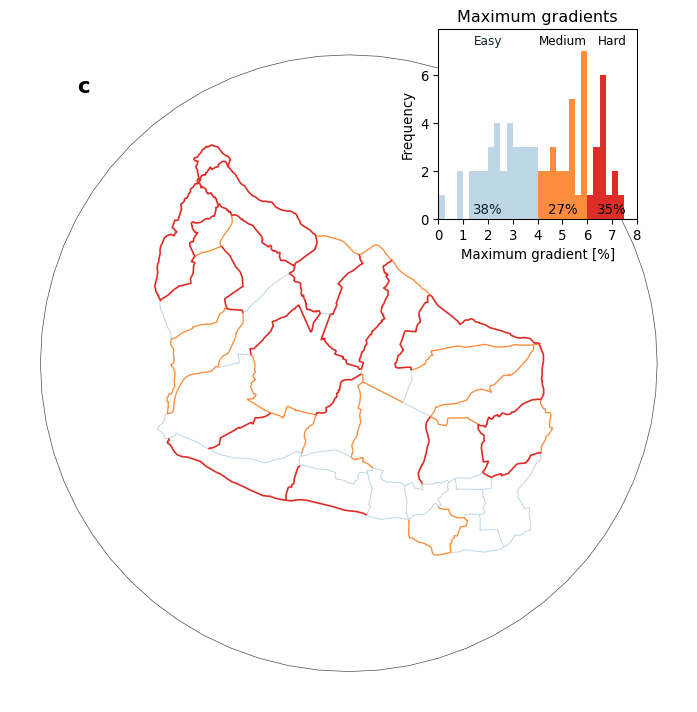

In [18]:
# Adapted from: scripts/script05.py
# in https://github.com/anastassiavybornova/bike-node-planner

# using momepy to get nodes and edges gdf with corresponding labels and geometry objects
nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)
nodes = nodes.set_crs(proj_crs)
edges = edges.set_crs(proj_crs)

### Classify edge slopes (in %)

edges["maxslope_class"] = edges.max_slope.apply(
    lambda x: classify_maxslope(
        maxslope=x,
        maxslope_medium=SCENARIO[1]["maxslope_limit"],
        maxslope_hard=SCENARIO[0]["maxslope_limit"],
    )
)

edges.to_file(PATH["data_out"] + f"edges_maxslope_classification.gpkg", index=False)

for classification in edges.maxslope_class.unique():
    fp = PATH["data_out"] + f"edges_{classification}.gpkg"
    edges[edges["maxslope_class"] == classification].to_file(fp, index=False)


fig, ax = plot_dk_gdf(
    None,
    edges,
    link_width=0,
    subplotlabel="c",
)

for classification in edges.maxslope_class.unique():
    df = gpd.read_file(PATH["data_out"] + f"edges_{classification}.gpkg")
    df = df.set_crs(proj_crs)
    df.plot(
        ax=ax,
        color=PLOTPARAM["maxslope_classification_colors"][classification],
        aspect=1,
        linewidth=PLOTPARAM["maxslope_classification_linewidths"][classification],
    )

xmax = 8
axes = fig.add_axes([0.64, 0.69, 0.31, 0.25])
maxslopes = [e["max_slope"] for e in G.es]

N, bins, patches = axes.hist(
    maxslopes,
    bins=list(np.linspace(0, xmax, 4 * xmax + 1)),
    density=False,
    linewidth=0,
)

# Source: https://stackoverflow.com/a/49290555
for i in range(0, 4 * SCENARIO[1]["maxslope_limit"]):
    patches[i].set_facecolor(PLOTPARAM["maxslope_classification_colors"]["easy"])
for i in range(4 * SCENARIO[1]["maxslope_limit"], 4 * SCENARIO[0]["maxslope_limit"]):
    patches[i].set_facecolor(PLOTPARAM["maxslope_classification_colors"]["medium"])
for i in range(4 * SCENARIO[0]["maxslope_limit"], len(patches)):
    patches[i].set_facecolor(PLOTPARAM["maxslope_classification_colors"]["hard"])

axes.set_xlabel("Maximum gradient [%]")
axes.set_ylabel("Frequency")
axes.set_title("Maximum gradients")
axes.text(
    (SCENARIO[1]["maxslope_limit"] + SCENARIO[0]["maxslope_limit"]) / 2,
    max(N) * 1.1,
    "Medium",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["maxslope_classification_colors"]["medium"], 3),
    fontsize=9,
)
axes.text(
    (SCENARIO[1]["maxslope_limit"] + SCENARIO[0]["maxslope_limit"]) / 2,
    max(N) * 0.1,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(maxslopes)
                    if (
                        x >= SCENARIO[1]["maxslope_limit"]
                        and x <= SCENARIO[0]["maxslope_limit"]
                    )
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["maxslope_classification_colors"]["medium"], 3),
)
axes.text(
    SCENARIO[1]["maxslope_limit"] * 0.5,
    max(N) * 1.1,
    "Easy",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["maxslope_classification_colors"]["easy"], 5),
    fontsize=9,
)
axes.text(
    SCENARIO[1]["maxslope_limit"] * 0.5,
    max(N) * 0.1,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(maxslopes)
                    if (x <= SCENARIO[1]["maxslope_limit"])
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["maxslope_classification_colors"]["easy"], 5),
)
axes.text(
    (SCENARIO[0]["maxslope_limit"] + xmax) / 2,
    max(N) * 1.1,
    "Hard",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["maxslope_classification_colors"]["hard"], 2.2),
    fontsize=9,
)
axes.text(
    (SCENARIO[0]["maxslope_limit"] + xmax) / 2,
    max(N) * 0.1,
    str(
        round(
            len(
                [
                    i
                    for i, x in enumerate(maxslopes)
                    if (x > SCENARIO[0]["maxslope_limit"])
                ]
            )
            / len(linklengths)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["maxslope_classification_colors"]["hard"], 2.2),
)

axes.set_xticks(list(range(xmax + 1)))
axes.set_xlim([0, xmax])
axes.set_ylim([0, 1.08 * axes.get_ylim()[1]])

fig.savefig(PATH["plot"] + "maxslopes" + "." + PLOTPARAM["format"])

### POI Diversity

#### Map with distribution

/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_58416/434654867.py:5: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)


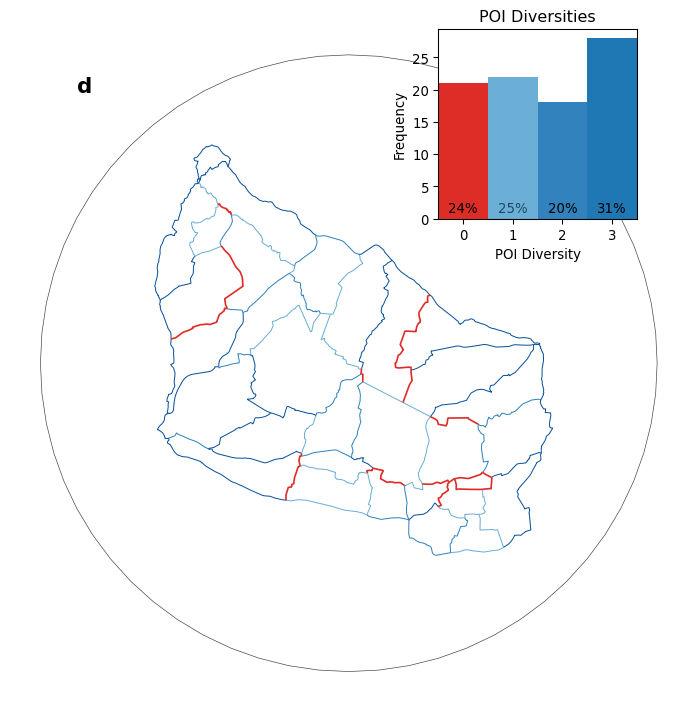

In [19]:
# Adapted from: scripts/script05.py
# in https://github.com/anastassiavybornova/bike-node-planner

# using momepy to get nodes and edges gdf with corresponding labels and geometry objects
nodes, edges = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)
nodes = nodes.set_crs(proj_crs)
edges = edges.set_crs(proj_crs)

for classification in edges.poi_diversity.unique():
    fp = PATH["data_out"] + f"edges_poidiversity{classification}.gpkg"
    edges[edges["poi_diversity"] == classification].to_file(fp, index=False)


fig, ax = plot_dk_gdf(
    None,
    edges,
    link_width=0,
    subplotlabel="d",
)

for classification in edges.poi_diversity.unique():
    df = gpd.read_file(PATH["data_out"] + f"edges_poidiversity{classification}.gpkg")
    df = df.set_crs(proj_crs)
    df.plot(
        ax=ax,
        color=PLOTPARAM["poidiversity_classification_colors"][classification],
        aspect=1,
        linewidth=PLOTPARAM["poidiversity_classification_linewidths"][classification],
    )

xmax = 3
axes = fig.add_axes([0.64, 0.69, 0.31, 0.25])
poidiversities = [e["poi_diversity"] for e in G.es]

N, bins, patches = axes.hist(
    poidiversities,
    bins=list(np.linspace(0, xmax + 1, xmax + 2)),
    density=False,
    linewidth=0,
)

# Source: https://stackoverflow.com/a/49290555

for i in range(3):
    patches[i].set_facecolor(PLOTPARAM["poidiversity_classification_colors"][i])

axes.set_xlabel("POI Diversity")
axes.set_ylabel("Frequency")
axes.set_title("POI Diversities")
axes.text(
    0.5,
    max(N) * 0.1,
    str(
        round(
            len([i for i, x in enumerate(poidiversities) if (x == 0)])
            / len(poidiversities)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["poidiversity_classification_colors"][0], 2.2),
)
axes.text(
    1.5,
    max(N) * 0.1,
    str(
        round(
            len([i for i, x in enumerate(poidiversities) if (x == 1)])
            / len(poidiversities)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["poidiversity_classification_colors"][1], 2),
)
axes.text(
    2.5,
    max(N) * 0.1,
    str(
        round(
            len([i for i, x in enumerate(poidiversities) if (x == 2)])
            / len(poidiversities)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["poidiversity_classification_colors"][2], 2),
)
axes.text(
    3.5,
    max(N) * 0.1,
    str(
        round(
            len([i for i, x in enumerate(poidiversities) if (x == 3)])
            / len(poidiversities)
            * 100
        )
    )
    + "%",
    horizontalalignment="center",
    verticalalignment="top",
    color=lighten_color(PLOTPARAM["poidiversity_classification_colors"][3], 2),
)

axes.set_xticks([0.5, 1.5, 2.5, 3.5])
axes.set_xticklabels([0, 1, 2, 3])
axes.set_xlim([0, xmax + 1])

fig.savefig(PATH["plot"] + "poidiversities" + "." + PLOTPARAM["format"])

## Correlations

In [20]:
poidiversities_np = np.array(poidiversities)
maxslopes_np = np.array(maxslopes)
linklengths_np = np.array(linklengths)

### Max gradient versus POI Diversity

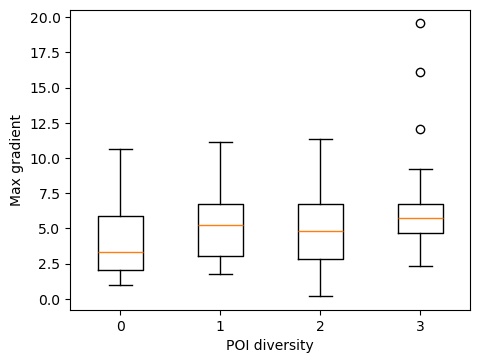

In [21]:
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1])

# Plot data
axes.boxplot(
    [
        maxslopes_np[poidiversities_np == 0],
        maxslopes_np[poidiversities_np == 1],
        maxslopes_np[poidiversities_np == 2],
        maxslopes_np[poidiversities_np == 3],
    ]
)
axes.set_ylabel("Max gradient")
axes.set_xticklabels([0, 1, 2, 3])
axes.set_xlabel("POI diversity");

### Link length versus POI Diversity

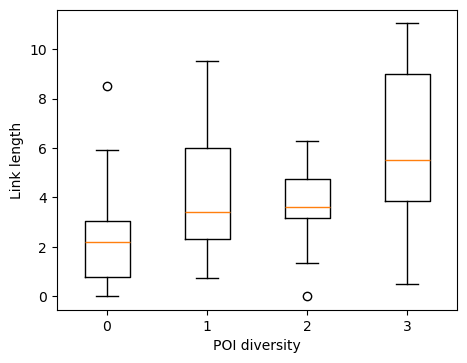

In [22]:
fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1])

# Plot data
axes.boxplot(
    [
        linklengths_np[poidiversities_np == 0],
        linklengths_np[poidiversities_np == 1],
        linklengths_np[poidiversities_np == 2],
        linklengths_np[poidiversities_np == 3],
    ]
)
axes.set_ylabel("Link length")
axes.set_xticklabels([0, 1, 2, 3])
axes.set_xlabel("POI diversity");

### Max gradient versus Link length

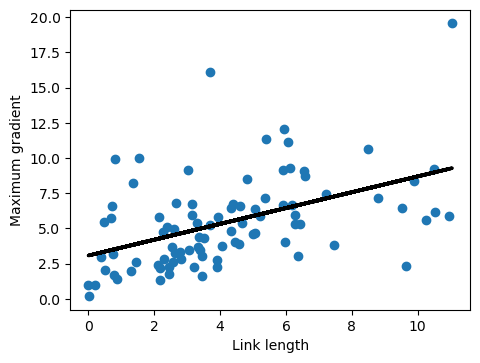

In [23]:
import scipy.stats as stats

fig = plt.figure(figsize=(4, 3))
axes = fig.add_axes([0, 0, 1, 1])

# Plot data
axes.scatter(linklengths_np, maxslopes_np)

# Plot fit
slope, intercept, r_value, _, _ = stats.linregress(linklengths_np, maxslopes_np)
line = slope * linklengths_np + intercept
axes.plot(linklengths_np, line, linewidth=2.5, color="k", label="Fit")

axes.set_xlabel("Link length")
axes.set_ylabel("Maximum gradient");